## Let's start looking at the communicative context of calls. 
## - Cluster 2 or 3 calls at a time, instead of just 1
## - Start by looking at the intervals between calls
## - I've clustered calls into categories in two different ways and I need to combine them or whatever
## - The biosound H5 files don't have this info, so I'll be extracting it from the soundsep segment filenames


## so far I've found that there is some contamination of the data, primarily sometimes one call gets double labeled as a call on two channels, which then makes it look like a bird is responding extremely quickly to another.
## I'm now excluding these from the dataset, excluding all tets that either come 7.5 ms before or after another tet.

# I need to start making finalish figures for a grant.

## what do I want to do with these gap durations... 
## and then of course the question is how to bring it all back to big ideas.
## TODO Rhythm figure
## TODO which calls follow each other? - DCs respond to DCs, etc? This could be done with playbacks as well.
## super tricky playback situation where you secretly remove the mate. 

In [1]:
# from scipy import integrate, optimize

import matplotlib.pyplot as plt
from scipy.signal import spectrogram, butter, sosfilt, sosfiltfilt, correlate
from scipy.io.wavfile import read, write
import IPython.display as ipd
# import sys
from collections import Counter
import os
import pandas as pd
# import pandas as pd
import numpy as np
import matplotlib.colors as mcolors
import pickle
import csv
from soundsig.sound import BioSound 
from soundsig.sound import WavFile

# Dimension reduction and clustering libraries
import umap
import hdbscan
import sklearn.cluster as cluster
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score
from sklearn.decomposition import PCA

In [2]:
# we have wav files in a folder, H5 files in a folder, and soundsep data. 

base_folder = '/Users/williamwood/Documents/Data/Field Station Recordings/for_soundsep/14_38_03_18_07_2023/'

soundsep_file_name = os.path.join(base_folder,'_appdata','save','segments.csv')
wave_files_folder = os.path.join(base_folder,'wavs')
spectrogram_folder = os.path.join(base_folder,'spec_results')

# Load the soundsep data
print(soundsep_file_name)
df = pd.read_csv(soundsep_file_name, sep=',',header=0)        
print(f'Length of dataframe: {len(df)}')
print(f'Column names: {df.columns}')
print(f'Tags: {df["Tags"].unique()}')

# Load the wav filenames to compare with the soundsep data for consistency.
wav_list = [f for f in os.listdir(os.path.join(base_folder,'wavs')) if f.endswith('.wav')]
wav_lengths = [read(os.path.join(base_folder,'wavs',f))[1].shape[0] for f in wav_list]  
shortest_file = wav_list[np.argmin(wav_lengths)]
fs, data = read(os.path.join(base_folder,'wavs', shortest_file))

# Load the spectrogram data to compare with the soundsep data for consistency.
spec_cluster_labels = np.load(os.path.join(base_folder,'spec_results','cluster_labels.npy'))

print(f'sampling rate is {fs}')
if fs != 44100:
    print('Sampling rate is not 44100 Hz. be careful.')

/Users/williamwood/Documents/Data/Field Station Recordings/for_soundsep/14_38_03_18_07_2023/_appdata/save/segments.csv
Length of dataframe: 4344
Column names: Index(['Unnamed: 0', 'SourceName', 'SourceChannel', 'StartIndex', 'StopIndex',
       'Tags', 'cluster', 'coords'],
      dtype='object')
Tags: ['["8"]' '["tet"]' '["hat"]' '["2"]' '["call"]' '["3"]' '["WF"]' '["DC"]'
 '["-2"]']
sampling rate is 48000
Sampling rate is not 44100 Hz. be careful.


In [3]:
# let's at least make sure the wav files are in the same order as the soundsep data
# we'll just check that the lengths of the wav files are the same as the lengths of the soundsep data
# and that the names are the same (maybe) 
# and that the spectrogram data is the same length as the soundsep data (maybe)

if len(df) != len(wav_list):
    print('Dataframe length does not match wav file length')
    print(f'Length of dataframe: {len(df)}')
    print(f'Length of wav files: {len(wav_list)}')
else:
    print('Dataframe length matches wav file length')

if len(df) != len(spec_cluster_labels):
    print('Dataframe length does not match cluster label length')
    print(f'Length of dataframe: {len(df)}')
    print(f'Length of cluster labels: {len(spec_cluster_labels)}')
else:
    print('Dataframe length matches cluster label length')

# TODO - check that the wav files are in the same order as the soundsep data
# TODO - check that the wav files are in the same order as the cluster labels



Dataframe length matches wav file length
Dataframe length matches cluster label length


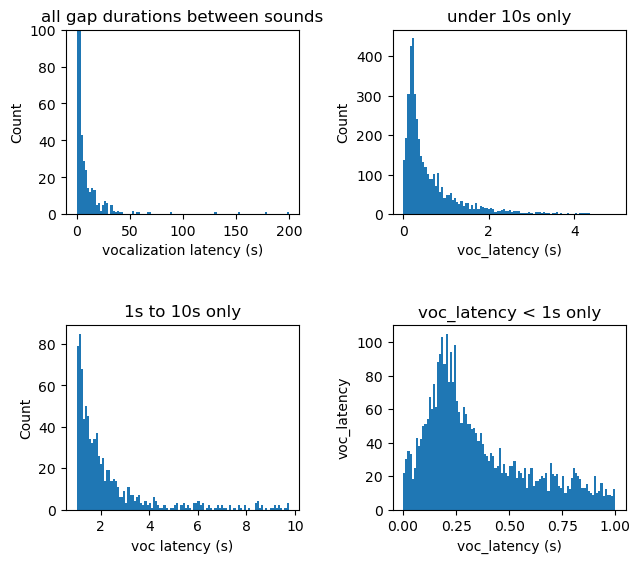

In [4]:
# calculate the gap durations between each sound
# we'll use the soundsep data for this
# df['StartIndex'][0]
df['voc_latency'] = df['StartIndex'].diff()
df['voc_latency'] /= fs

# plot a histogram of the gap durations

plt.figure(figsize=(7,6))
plt.subplot(2,2,1)
plt.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9, wspace=0.4, hspace=0.6)

plt.hist(df['voc_latency'], bins=100)
plt.ylim(0,100)
plt.xlabel('vocalization latency (s)')
plt.ylabel('Count')
plt.title('all gap durations between sounds')

shortish_gap_index = (df['voc_latency']  < 5)
shortish_gaps = df['voc_latency'][shortish_gap_index]
plt.subplot(2,2,2)
plt.hist(shortish_gaps, bins=100)
plt.xlabel('voc_latency (s)')
plt.ylabel('Count')
plt.title('under 10s only')


medium_gap_index = (df['voc_latency'] > 1) & (df['voc_latency'] < 10)
medium_gaps = df['voc_latency'][medium_gap_index]
plt.subplot(2,2,3)
plt.hist(medium_gaps, bins=100)
plt.xlabel('voc latency (s)')
plt.ylabel('Count')
plt.title('1s to 10s only')

# middish_gap_index = (df['voc_latency'] < 100)
# middish_gaps = df['voc_latency'][middish_gap_index]
# plt.subplot(2,2,3)
# plt.hist(middish_gaps, bins=100)
# plt.xlabel('voc latency (s)')
# plt.ylabel('Count')
# plt.title('Under 100 s only')


# plot a histogram of the gap durations zoomed in on the short gaps
# take the gap_durations that are less than 1 second and put them in a variable to make a histogram
short_gap_index = (df['voc_latency'] < 1).values
short_gaps = df['voc_latency'][short_gap_index]
plt.subplot(2,2,4)
plt.hist(short_gaps, bins=100)
plt.xlabel('voc_latency (s)')
plt.ylabel('voc_latency')
plt.title('voc_latency < 1s only')



plt.show()


# Ok that's surprisingly interesting already.
## I want to calculate which call types follow which call types and what the durations are between different types of call types

In [5]:
# rough calculation of how many calls per second
# we'll just divide the number of calls by the total duration of the recording
total_duration = 90*60 # 90 minutes- substantial parts of the recording have gaps so it's better to have a rough estimate here
total_calls = len(df)
calls_per_second = total_calls / total_duration
print(f'# of callsf: {total_calls} calls per second: {calls_per_second}')

# of callsf: 4344 calls per second: 0.8044444444444444


In [9]:
for call_type in np.unique(spec_cluster_labels):
    print(f'Call type: {call_type}')
    call_index = (spec_cluster_labels == call_type)
    call_index = call_index & (df['gap_duration'] < 5)
    call_gaps = df['gap_duration'][call_index]
    plt.figure()
    plt.hist(call_gaps, bins=100)
    plt.xlabel('Gap duration (s)')
    plt.ylabel('Count')
    plt.title(f'spectrogram based call type: {call_type} gap durations')
    plt.show()

Call type: 0


KeyError: 'gap_duration'

In [10]:
# do the same thing with the labels from the soundsep data
for call_type in np.unique(df['Tags']):
    print(f'Call type: {call_type}')
    call_index = (df['Tags'] == call_type)
    call_index = call_index & (df['gap_duration'] < 5)
    call_gaps = df['gap_duration'][call_index]
    plt.figure()
    plt.hist(call_gaps, bins=100)
    plt.xlabel('Gap duration (s)')
    plt.ylabel('Count')
    plt.title(f'soundsep based call type: {call_type} gap durations')
    plt.show()

Call type: ["-2"]


KeyError: 'gap_duration'

# The following cell (+1) calculates gap durations and simultaneously excludes super short gaps that are often errors in sorting. 
# I was trying to find calls that were being recorded on two channels, as two calls (when it was really 1). I have made this simultaneity as that is the right way to capture it
# HOWEVER I believe it cuts too many vocalizations so I need to be careful about this

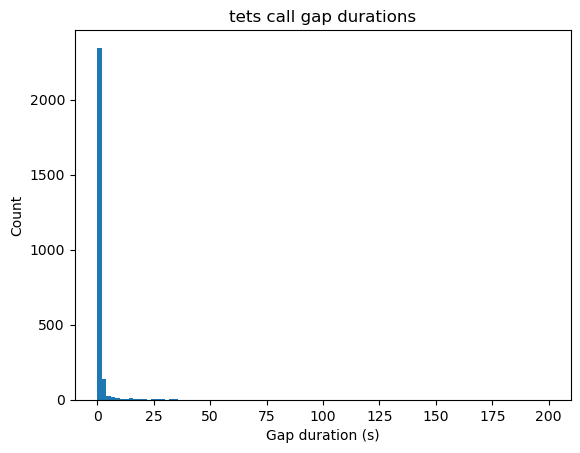

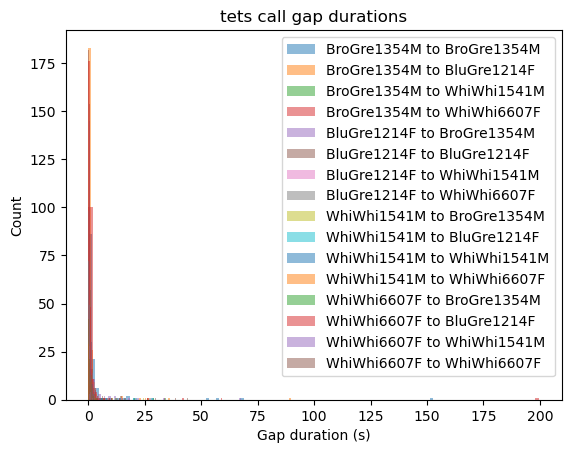

This is how often each bird responds to each other bird


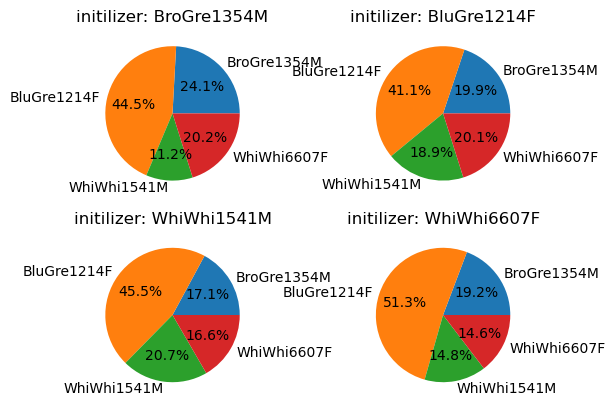

In [7]:
# I want to focus on tets (soundsep based) and look at how quickly birds are calling after each other
# I want to look at the gap durations between tets calls
# let's plot the gap durations between tets calls of different individuals vs the gap durations between tets calls of the same individual
# first, let's get the gap durations between tet calls of all individuals and stick them in a dictionary of dictionaries of lists
# in a given exchange, the vocalizer is the first call and the responder is the second call, and that's how we'll store the gap durations
# gap_duration_dict[vocalizer][responder].append(gap_duration)

birds = df['SourceName'].unique()

gap_duration_dict = {bird: [] for bird in birds}
gap_duration_dict['BluGre1214F'] = {bird: [] for bird in birds}
gap_duration_dict['BroGre1354M'] = {bird: [] for bird in birds}
gap_duration_dict['WhiWhi1541M'] = {bird: [] for bird in birds}
gap_duration_dict['WhiWhi6607F'] = {bird: [] for bird in birds}

simultaneity_dict = {bird: [] for bird in birds}
simultaneity_dict['BluGre1214F'] = {bird: [] for bird in birds}
simultaneity_dict['BroGre1354M'] = {bird: [] for bird in birds}
simultaneity_dict['WhiWhi1541M'] = {bird: [] for bird in birds}
simultaneity_dict['WhiWhi6607F'] = {bird: [] for bird in birds}


# initialize lists for each bird pair
gap_duration_dict['BluGre1214F']['BluGre1214F'] = list()
gap_duration_dict['BluGre1214F']['BroGre1354M'] = list()
gap_duration_dict['BluGre1214F']['WhiWhi1541M'] = list()
gap_duration_dict['BluGre1214F']['WhiWhi6607F'] = list()
gap_duration_dict['BroGre1354M']['BluGre1214F'] = list()
gap_duration_dict['BroGre1354M']['BroGre1354M'] = list()
gap_duration_dict['BroGre1354M']['WhiWhi1541M'] = list()
gap_duration_dict['BroGre1354M']['WhiWhi6607F'] = list()
gap_duration_dict['WhiWhi1541M']['BluGre1214F'] = list()
gap_duration_dict['WhiWhi1541M']['BroGre1354M'] = list()
gap_duration_dict['WhiWhi1541M']['WhiWhi1541M'] = list()
gap_duration_dict['WhiWhi1541M']['WhiWhi6607F'] = list()
gap_duration_dict['WhiWhi6607F']['BluGre1214F'] = list()
gap_duration_dict['WhiWhi6607F']['BroGre1354M'] = list()
gap_duration_dict['WhiWhi6607F']['WhiWhi1541M'] = list()
gap_duration_dict['WhiWhi6607F']['WhiWhi6607F'] = list()

exclude_by_simultaneity_list = list()

for i in range(len(df)-1):
    if df['Tags'][i] == '["tet"]':
        if df['Tags'][i+1] == '["tet"]':
            vocalizer = df['SourceName'][i]
            responder = df['SourceName'][i+1]
            simultaneity = (df['StartIndex'][i+1]-df['StartIndex'][i])/fs
            if simultaneity < 0.015:
                # print(f'{vocalizer} to {responder}: {simultaneity}, i: {i}, index: {df.index[i]}')
                # print(f"start time i,i+1: {df['StartIndex'][i]/fs}, {df['StartIndex'][i+1]/fs}")
                exclude_by_simultaneity_list.append(i)
                simultaneity_dict[vocalizer][responder].append(simultaneity)
                gap_duration = (df['StartIndex'][i+1]-df['StartIndex'][i])/fs # comment out if you want to exclude based on simultaneity
                gap_duration_dict[vocalizer][responder].append(gap_duration) # comment out if you want to exclude based on simultaneity
            else:
                gap_duration = (df['StartIndex'][i+1]-df['StartIndex'][i])/fs
                gap_duration_dict[vocalizer][responder].append(gap_duration)


# # now we have a dictionary of gap durations between each bird
# # let's plot the gap durations
# # first, let's plot all the gap durations in one histogram
# # then, let's plot the gap durations between each pair of birds in a histogram
# # then, let's plot a pie chart of how often each bird responds to each other bird

# plot all the gap durations in one histogram, irrespective of who is calling
plt.figure()
all_gaps = []
for bird1 in gap_duration_dict:
    for bird2 in gap_duration_dict[bird1]:
        all_gaps += gap_duration_dict[bird1][bird2]
plt.hist(all_gaps, bins=100)
plt.xlabel('Gap duration (s)')
plt.ylabel('Count')
plt.title('tets call gap durations')


plt.figure()
for bird1 in gap_duration_dict:
    for bird2 in gap_duration_dict[bird1]:
        plt.hist(gap_duration_dict[bird1][bird2], bins=100, alpha=0.5, label=f'{bird1} to {bird2}')
plt.xlabel('Gap duration (s)')
plt.ylabel('Count')
plt.title('tets call gap durations')
plt.legend()
plt.show()

# let's plot pie charts of how often each bird responds to each other bird
# we'll have 4 pie charts
print(f'This is how often each bird responds to each other bird')
plt.figure()
for i, bird1 in enumerate(gap_duration_dict):
    plt.subplot(2,2,i+1)
    plt.pie([len(gap_duration_dict[bird1][bird2]) for bird2 in gap_duration_dict[bird1]], labels=[bird2 for bird2 in gap_duration_dict[bird1]], autopct='%1.1f%%')
    plt.title(f'initilizer: {bird1}')
plt.show()



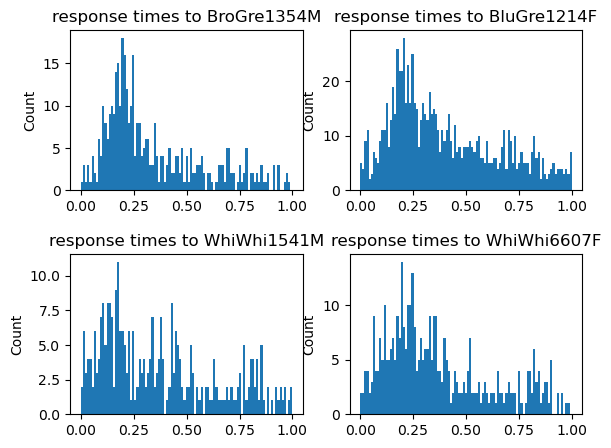

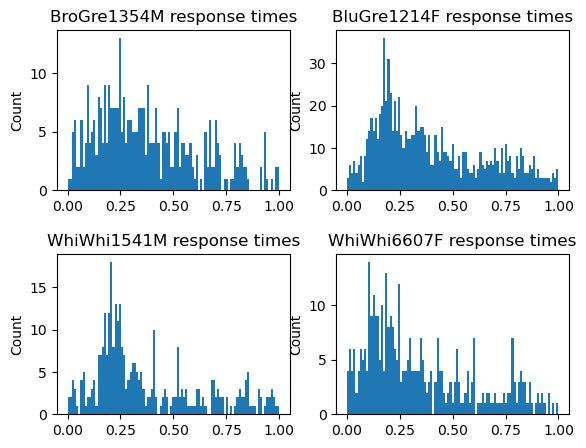

In [8]:
# just return the gap duration for one bird against all others
# we'll return the gap durations for each bird against all others


def get_gap_durations(bird_name, gap_duration_dict):
    # given a bird name, return the gap durations for that bird against all others
    # meaning, return the gap durations for that bird as the initial vocalizer
    # meaning, how fast all the other birds respond to that bird
    gap_durations = []
    for bird in gap_duration_dict:
        gap_durations += gap_duration_dict[bird_name][bird]
    return gap_durations

def get_gap_durations_responder(bird_name, gap_duration_dict):
    gap_durations = []
    for bird in gap_duration_dict:
        gap_durations += gap_duration_dict[bird][bird_name]
    return gap_durations

# let's plot the gap durations for each bird against all others
# let's set the x axis to be max_gap seconds
# let's plot a histogram for each bird

max_gap = 1.0
bins = np.linspace(0, max_gap, 100)
plt.figure()
for i, bird in enumerate(gap_duration_dict):
    plt.subplot(2,2,i+1)
    plt.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9, wspace=0.2, hspace=0.4)
    plt.hist(get_gap_durations(bird, gap_duration_dict), bins=bins)
    # plt.xlabel('Gap duration (s)')
    plt.ylabel('Count')
    plt.title(f'response times to {bird}')
plt.show()

# now let's plot the same thing but in terms of the responder, not the vocalizer
# let's plot the gap durations for each bird against all others
# let's set the x axis to be max_gap seconds
# let's plot a histogram for each bird
# make my subplots a little bigger and a little further apart


bins = np.linspace(0, max_gap, 100)
plt.figure()
for i, bird in enumerate(gap_duration_dict):
    plt.subplot(2,2,i+1)
    plt.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9, wspace=0.2, hspace=0.4)
    plt.hist(get_gap_durations_responder(bird, gap_duration_dict), bins=bins)
    # plt.xlabel('Gap duration (s)')
    plt.ylabel('Count')
    plt.title(f'{bird} response times')
plt.show()


In [11]:
# histogram of all gap durations
plt.figure()
plt.hist(all_gap_durations, bins=100)
plt.xlabel('Gap duration (s)')
plt.ylabel('Count')
plt.title('all gap durations between sounds')

NameError: name 'all_gap_durations' is not defined

<Figure size 640x480 with 0 Axes>

bird: BroGre1354M


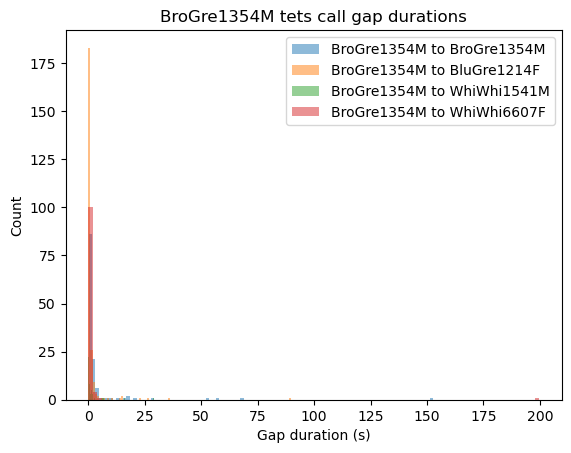

bird: BluGre1214F


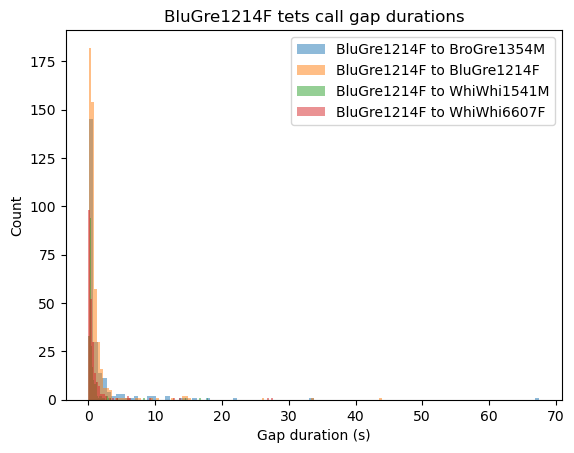

bird: WhiWhi1541M


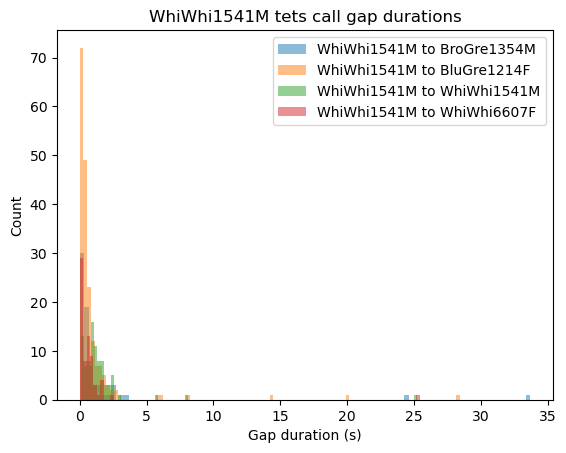

bird: WhiWhi6607F


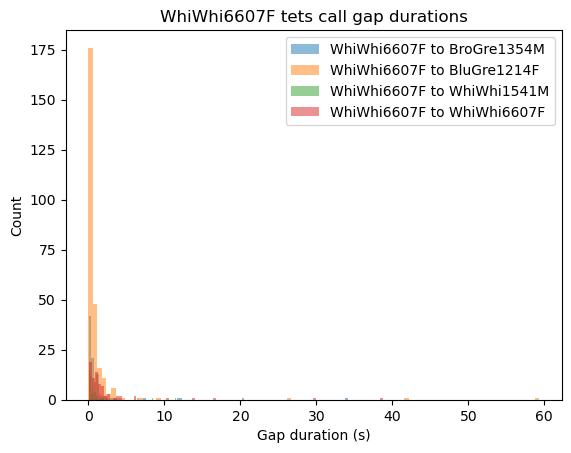

In [27]:
# plot a histogram of each birds tet call gaps
for bird in gap_duration_dict:
    print(f'bird: {bird}')
    plt.figure()
    for responder in gap_duration_dict[bird]:
        plt.hist(gap_duration_dict[bird][responder], bins=100, alpha=0.5, label=f'{bird} to {responder}')
    plt.xlabel('Gap duration (s)')
    plt.ylabel('Count')
    plt.title(f'{bird} tets call gap durations')
    plt.legend()
    plt.show()

In [12]:
def print_interval(i):
    # print the time between the ith and ith+1 call in and seconds and ms
    gap_duration = ((df['StartIndex'][i+1]-df['StartIndex'][i])/fs)
    # time in minutes and seconds
    time = df['StartIndex'][i]/fs
    minutes = int(time/60)
    seconds = time - minutes*60
    print(f'Gap duration: {gap_duration*1000} milliseconds')
    print(f'Time: {minutes}:{seconds}')

for i in range(10):
    print(f'i={i}, index= {exclude_by_simultaneity_list[i]}')
    print_interval(exclude_by_simultaneity_list[i])



i=0, index= 89
Gap duration: 0.7083333333333334 milliseconds
Time: 2:19.803854166666667
i=1, index= 351
Gap duration: 11.6875 milliseconds
Time: 8:1.5428541666666433
i=2, index= 554
Gap duration: 13.458333333333332 milliseconds
Time: 9:54.88116666666667
i=3, index= 618
Gap duration: 4.291666666666667 milliseconds
Time: 10:44.07524999999998
i=4, index= 776
Gap duration: 12.645833333333334 milliseconds
Time: 13:9.90462500000001
i=5, index= 943
Gap duration: 1.2708333333333333 milliseconds
Time: 15:15.770833333333371
i=6, index= 1527
Gap duration: 1.25 milliseconds
Time: 27:55.62958333333336
i=7, index= 1591
Gap duration: 0.3333333333333333 milliseconds
Time: 28:33.49339583333335
i=8, index= 2054
Gap duration: 5.645833333333333 milliseconds
Time: 42:52.25077083333326
i=9, index= 2084
Gap duration: 13.4375 milliseconds
Time: 43:4.499854166666864


In [29]:
# Take one more look at the short gap duration tets of 

# OK indeed we find a few problems with our simultaneity probe, but we also find that about half of them are fine. So I'm really not worried about 34 / 4300.
# The bigger problem right now is that female DCs are getting clumped with tets. Let's take a look at the distribution of call lengths by these birds, and then break it down into individual call types.


In [30]:
# I want to tak

In [13]:
# I need to prove to myself these are actually bad calls.
# I will look at the spectrograms of the calls that are too close together in another program, I just want to identify them here
# exclude_by_gap_list
gap_duration_dict

{'BroGre1354M': {'BroGre1354M': [3.5855208333333333,
   2.0674375,
   0.8361458333333334,
   3.6481666666666666,
   0.4182708333333333,
   2.2933958333333333,
   1.4247083333333332,
   0.6968125,
   0.693375,
   0.20245833333333332,
   1.0734166666666667,
   0.3900625,
   1.6211875,
   0.12414583333333333,
   4.4404375,
   0.911,
   0.1670625,
   0.08072916666666667,
   0.5417083333333333,
   0.08952083333333333,
   0.05297916666666667,
   0.4475,
   1.6348958333333334,
   0.08602083333333334,
   1.9576875,
   1.046125,
   0.55425,
   0.6693541666666667,
   0.2838541666666667,
   0.34379166666666666,
   0.37554166666666666,
   3.8364166666666666,
   0.3461875,
   0.9332916666666666,
   0.658375,
   0.35152083333333334,
   0.4453958333333333,
   10.389479166666666,
   0.5425,
   0.7143125,
   0.773625,
   1.4924583333333334,
   0.21777083333333333,
   0.09433333333333334,
   1.6071666666666666,
   56.705020833333336,
   8.517333333333333,
   0.4729583333333333,
   16.0538125,
   0.77816

## after excluding files the df index no longer lines up need to make a new df with a clean index I guess
## I don't really love this solution but it does work

In [ ]:
# # # #make a new DF excluding the short gaps
# df_exclude = df.drop(exclude_by_gap_list)
# len(df_exclude)
# df_exclude.to_csv(os.path.join(base_folder,'spec_results','segments_exclude_65ms_gaps.csv'), index=False)
# df_old = df.copy()
# df = df_exclude.copy()
# # let's make the index of the dataframe the same as the index of the clusters, meaning just linearize the index
# df.index = np.arange(len(df))

# # we also need to exclude the short gaps from the cluster labels
# spec_cluster_labels_exclude = np.delete(spec_cluster_labels, exclude_by_gap_list)




In [32]:
# # I want to focus on tets (soundsep based) and look at how quickly birds are calling after each other
# # I want to look at the gap durations between tets calls
# # let's plot the gap durations between tets calls of different individuals vs the gap durations between tets calls of the same individual
# # first, let's get the gap durations between tet calls of all individuals and stick them in a dictionary of dictionaries of lists
# birds = df['SourceName'].unique()

# gap_duration_dict = {bird: [] for bird in birds}
# gap_duration_dict['BluGre1214F'] = {bird: [] for bird in birds}
# gap_duration_dict['BroGre1354M'] = {bird: [] for bird in birds}
# gap_duration_dict['WhiWhi1541M'] = {bird: [] for bird in birds}
# gap_duration_dict['WhiWhi6607F'] = {bird: [] for bird in birds}

# # initialize lists for each bird pair
# gap_duration_dict['BluGre1214F']['BluGre1214F'] = list()
# gap_duration_dict['BluGre1214F']['BroGre1354M'] = list()
# gap_duration_dict['BluGre1214F']['WhiWhi1541M'] = list()
# gap_duration_dict['BluGre1214F']['WhiWhi6607F'] = list()
# gap_duration_dict['BroGre1354M']['BluGre1214F'] = list()
# gap_duration_dict['BroGre1354M']['BroGre1354M'] = list()
# gap_duration_dict['BroGre1354M']['WhiWhi1541M'] = list()
# gap_duration_dict['BroGre1354M']['WhiWhi6607F'] = list()
# gap_duration_dict['WhiWhi1541M']['BluGre1214F'] = list()
# gap_duration_dict['WhiWhi1541M']['BroGre1354M'] = list()
# gap_duration_dict['WhiWhi1541M']['WhiWhi1541M'] = list()
# gap_duration_dict['WhiWhi1541M']['WhiWhi6607F'] = list()
# gap_duration_dict['WhiWhi6607F']['BluGre1214F'] = list()
# gap_duration_dict['WhiWhi6607F']['BroGre1354M'] = list()
# gap_duration_dict['WhiWhi6607F']['WhiWhi1541M'] = list()
# gap_duration_dict['WhiWhi6607F']['WhiWhi6607F'] = list()

# exclude_by_gap_list = list()
# for i in range(len(df)-1):
#     if df['Tags'][i] == '["tet"]':
#         vocalizer = df['SourceName'][i]
#         responder = df['SourceName'][i+1]
#         response = df['Tags'][i+1]
#         if response == '["tet"]':
#             gap_duration = (df['StopIndex'][i]-df['StartIndex'][i])/fs

#             if gap_duration < 0.075:
#                 # print(f'{vocalizer} to {responder}: {gap_duration}, index: {i}')
#                 exclude_by_gap_list.append(i)
#             else:
#                 gap_duration_dict[vocalizer][responder].append(gap_duration)

# # gap_duration_dict

# # now we have a dictionary of gap durations between each bird
# # let's plot the gap durations
# # first, let's plot all the gap durations in one histogram
# # then, let's plot the gap durations between each pair of birds in a histogram
# # then, let's plot a pie chart of how often each bird responds to each other bird

# # plot all the gap durations in one histogram, irrespective of who is calling
# plt.figure()
# all_gaps = []
# for bird1 in gap_duration_dict:
#     for bird2 in gap_duration_dict[bird1]:
#         all_gaps += gap_duration_dict[bird1][bird2]
# plt.hist(all_gaps, bins=100)
# plt.xlabel('Gap duration (s)')
# plt.ylabel('Count')
# plt.title('tets call gap durations')


# plt.figure()
# for bird1 in gap_duration_dict:
#     for bird2 in gap_duration_dict[bird1]:
#         plt.hist(gap_duration_dict[bird1][bird2], bins=100, alpha=0.5, label=f'{bird1} to {bird2}')
# plt.xlabel('Gap duration (s)')
# plt.ylabel('Count')
# plt.title('tets call gap durations')
# plt.legend()
# plt.show()

# # let's plot pie charts of how often each bird responds to each other bird
# # we'll have 4 pie charts
# print(f'This is how often each bird responds to each other bird')
# plt.figure()
# for i, bird1 in enumerate(gap_duration_dict):
#     plt.subplot(2,2,i+1)
#     plt.pie([len(gap_duration_dict[bird1][bird2]) for bird2 in gap_duration_dict[bird1]], labels=[bird2 for bird2 in gap_duration_dict[bird1]], autopct='%1.1f%%')
#     plt.title(f'initilizer: {bird1}')
# plt.show()



In [33]:
# # ok actually we are going to exclude any tet that has a gap duration of less than 0.075 s
# # find the gap durations that are less than 0.075 s, either as the initiator or the responder
# # and exclude them from the analysis

# # first, let's plot all the gap durations in one histogram, irrespective of who is calling
# plt.figure()
# all_gaps = []
# for bird1 in gap_duration_dict:
#     for bird2 in gap_duration_dict[bird1]:
#         all_gaps += gap_duration_dict[bird1][bird2]
# plt.hist(all_gaps, bins=100)
# plt.xlabel('Gap duration (s)')
# plt.ylabel('Count')
# plt.title('tets call gap durations')

# # now, let's exclude the gap durations that are less than 0.075 s

# plt.figure()
# all_gaps = []
# for bird1 in gap_duration_dict:
#     for bird2 in gap_duration_dict[bird1]:
#         all_gaps += gap_duration_dict[bird1][bird2]
# all_gaps = np.array(all_gaps)
# all_gaps = all_gaps[all_gaps > 0.065]
# plt.hist(all_gaps, bins=100)
# plt.xlabel('Gap duration (s)')
# plt.ylabel('Count')
# plt.title('tets call gap durations, excluding gaps less than 0.065s')

# # I need the index of all the gap durations that are less than 0.075 s so I can exclude them from the original DF
# # I can then use the new DF to calculate the gap durations between each bird
# # and plot the histograms again




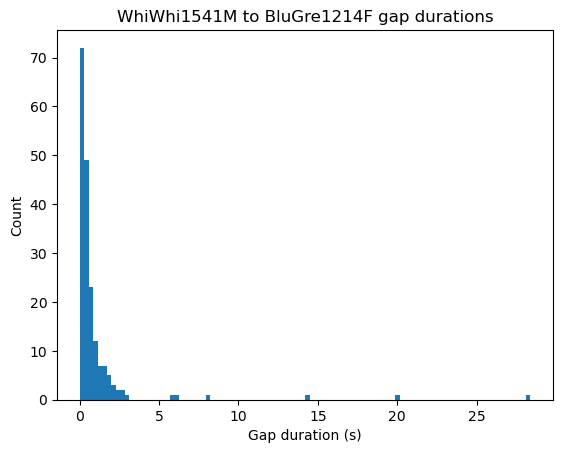

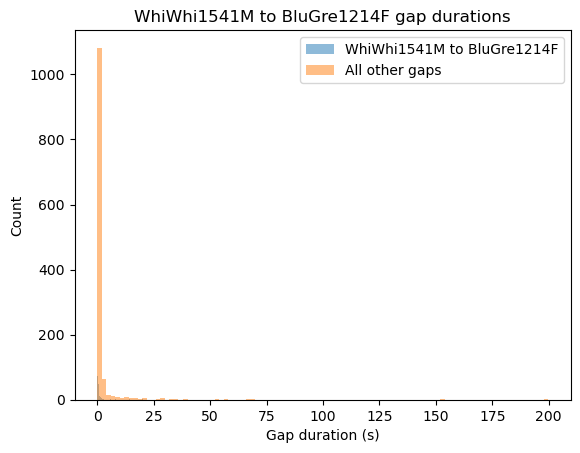

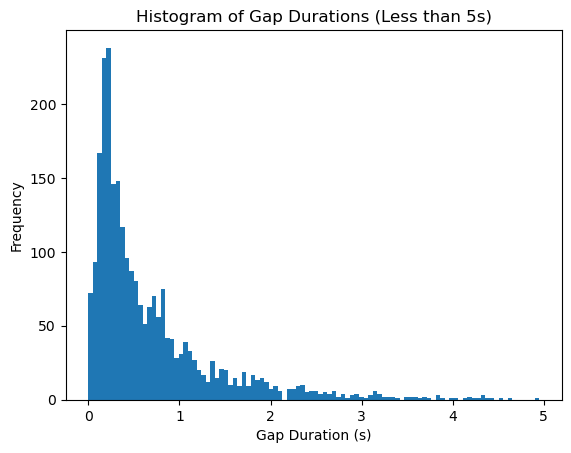

In [15]:
# plot the same histogram as above, but only for the pair of birds that has the shortest gap durations
# WhiWhi1541M to BluGre1214F
plt.figure()
plt.hist(gap_duration_dict['WhiWhi1541M']['BluGre1214F'], bins=100)
plt.xlabel('Gap duration (s)')
plt.ylabel('Count')
plt.title('WhiWhi1541M to BluGre1214F gap durations')

# plot the same histogram as above, contrasting with all the other gap durations combined
plt.figure()
plt.hist(gap_duration_dict['WhiWhi1541M']['BluGre1214F'], bins=100, alpha=0.5, label='WhiWhi1541M to BluGre1214F')
all_other_gaps = []
for bird1 in gap_duration_dict:
    for bird2 in gap_duration_dict[bird1]:
        if bird1 != 'WhiWhi1541M' and bird2 != 'BluGre1214F':
            all_other_gaps.extend(gap_duration_dict[bird1][bird2])
plt.hist(all_other_gaps, bins=100, alpha=0.5, label='All other gaps')
plt.xlabel('Gap duration (s)')
plt.ylabel('Count')
plt.title('WhiWhi1541M to BluGre1214F gap durations')
plt.legend()
plt.show

# Filter gap durations less than 5 seconds
filtered_gaps = [gap for gap in all_gaps if gap < 5]

# # Plot histogram
# plt.figure()
# plt.hist(filtered_gaps, bins=100)
# plt.xlabel('Gap Duration (s)')
# plt.ylabel('Frequency')
# plt.title('Histogram of Gap Durations (Less than 5s)')
# plt.show()

plt.figure()
plt.hist(gap_duration_dict['WhiWhi1541M']['BluGre1214F'], bins=100, alpha=0.5, label='WhiWhi1541M to BluGre1214F')
all_other_gaps = []
for bird1 in gap_duration_dict:
    for bird2 in gap_duration_dict[bird1]:
        if bird1 != 'WhiWhi1541M' and bird2 != 'BluGre1214F':
            all_other_gaps.extend(gap_duration_dict[bird1][bird2])
plt.hist(all_other_gaps, bins=100, alpha=0.5, label='All other gaps')
plt.xlabel('Gap duration (s)')
plt.ylabel('Count')
plt.title('WhiWhi1541M to BluGre1214F gap durations')
plt.legend()
plt.show


# to resave the segments.csv file for Quentin, minus the polluted tets


In [ ]:
# raw_df = pd.read_csv(soundsep_file_name, sep=',',header=0)        
# raw_df

,Unnamed: 0,SourceName,SourceChannel,StartIndex,StopIndex,Tags,cluster,coords
0,0,BroGre1354M,0,705034,709502,"[""tet""]",0.0,[11.813441 10.158026 8.204752]
1,1,BluGre1214F,2,739121,741816,"[""tet""]",5.0,[10.289108 8.867108 3.8716762]
2,2,BluGre1214F,2,773851,776369,"[""hat""]",1.0,[9.031709 7.9875793 2.4193041]
3,3,BluGre1214F,2,844891,848558,"[""tet""]",5.0,[10.432616 8.651451 3.9261248]
4,4,BroGre1354M,0,910549,913839,"[""tet""]",4.0,[10.93499 7.944698 0.92982405]
...,...,...,...,...,...,...,...,...
4339,4339,WhiWhi1541M,3,297302736,297305283,"[""tet""]",4.0,[12.446056 7.7917695 2.9063237]
4340,4340,BluGre1214F,2,297324812,297329004,"[""tet""]",5.0,[13.918158 10.1539955 3.8789632]
4341,4341,BluGre1214F,2,297367001,297371644,"[""tet""]",5.0,[14.02288 10.04855 4.029904]
4342,4342,BluGre1214F,2,298070022,298074525,"[""tet""]",5.0,[12.321278 9.2719965 5.2556705]


4344

<Figure size 640x480 with 0 Axes>

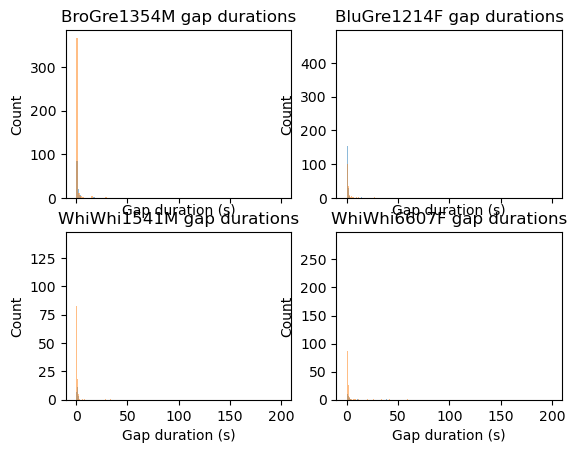

In [35]:
# plot each bird's gap durations against all others
# fix the x axis to be the same for all plots so we can compare them

plt.figure()
fig, axs = plt.subplots(2,2, sharex=True)
for i, bird1 in enumerate(gap_duration_dict):
    plt.subplot(2,2,i+1)
            # lump all the duratino of all other bids together
    all_other_gaps = []

    for bird2 in gap_duration_dict:
        if bird1 != bird2:
            all_other_gaps.extend(gap_duration_dict[bird1][bird2])
    # precalculate the x axis limits
    x_min = min(min(gap_duration_dict[bird1][bird1]), min(all_other_gaps))
    x_max = max(max(gap_duration_dict[bird1][bird1]), max(all_other_gaps))
    
    plt.hist(gap_duration_dict[bird1][bird1], bins=100, alpha=0.5, label=f'{bird1} to {bird1}')

    plt.hist(all_other_gaps, bins=100, alpha=0.5, label=f'{bird1} to all others')
    plt.xlabel('Gap duration (s)')

    plt.ylabel('Count')
    plt.title(f'{bird1} gap durations')
    # plt.legend()

plt.show()


<Figure size 640x480 with 0 Axes>

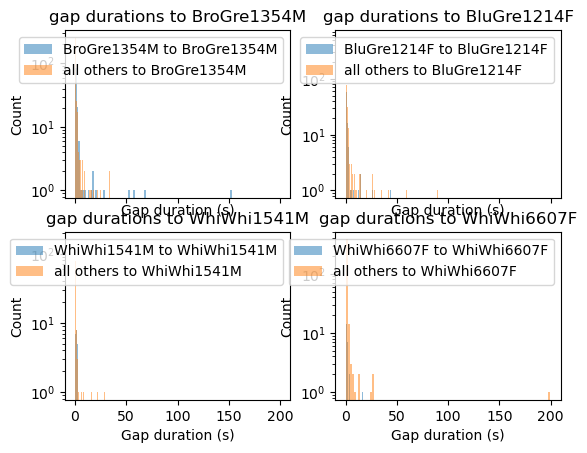

In [16]:
# plot the gap durations as a function of who is being responded to, and exluding the self responses
plt.figure()
fig, axs = plt.subplots(2,2, sharex=True)
for i, bird1 in enumerate(gap_duration_dict):
    plt.subplot(2,2,i+1)
    all_other_gaps = []
    for bird2 in gap_duration_dict:
        if bird1 != bird2:
            all_other_gaps.extend(gap_duration_dict[bird2][bird1])
    plt.hist(gap_duration_dict[bird1][bird1], bins=100, alpha=0.5, label=f'{bird1} to {bird1}',log=True)
    plt.hist(all_other_gaps, bins=100, alpha=0.5, label=f'all others to {bird1}', log = True)
    # ax.set_yscale('log')

    plt.xlabel('Gap duration (s)')
    plt.ylabel('Count')
    plt.title(f'gap durations to {bird1}')
    plt.legend()
plt.show()

This is how often each bird responds to each other bird


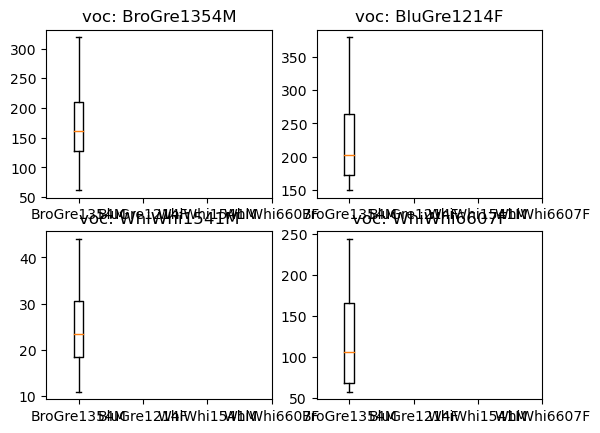

In [ ]:
# let's plot how often each bird responds to each other bird in a box and whisker plot
# we'll have 4 box and whisker plots
print(f'This is how often each bird responds to each other bird')
plt.figure()
for i, bird1 in enumerate(gap_duration_dict):
    plt.subplot(2,2,i+1)
    plt.boxplot([len(gap_duration_dict[bird1][bird2]) for bird2 in gap_duration_dict[bird1]])
    plt.xticks([1,2,3,4], [bird2 for bird2 in gap_duration_dict[bird1]])
    plt.title(f'voc: {bird1}')

## ok what's immediately noticeable is that padding with zeros is not great.  
## We could pad with silence, potentially of variable time, or at least somewhat.. Which might help extend our dataset (?)
## Ideally we would model the silence and insert that. 
## While this is promising, I want to move onto more promising things, like capturing the context of vocalizations. So I'm going to leave this for now.